In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os


In [ ]:
class MyDataset(tf.data.Dataset):
    def __init__(self, *args, **kwargs):
        super().__init__(**kwargs)  # <- important
        # your code here


In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32

ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'C:\Aakash PDFs\Cyber S4\ML\Project\DataSet',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'C:\Aakash PDFs\Cyber S4\ML\Project\DataSet',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2531 images belonging to 2 classes.
Found 2531 images belonging to 2 classes.


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False  # Freeze initial layers

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# base_model.trainable = False  # Freeze base
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False  # Freeze initial layers

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-7)
]


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


c:\Users\hunny\anaconda3\envs\tf-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9165 - loss: 0.2485 - val_accuracy: 0.5847 - val_loss: 0.6841


In [ ]:
base_model.trainable = True

# Fine-tune from this layer onward
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


80/80 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9787 - loss: 0.0520 - val_accuracy: 0.8167 - val_loss: 0.6400


In [15]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc:.2f}")


80/80 ━━━━━━━━━━━━━━━━━━━━ 56s 700ms/step - accuracy: 0.8137 - loss: 0.6404
Validation Accuracy: 0.82


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 755ms/step


C:\Users\hunny\AppData\Local\Temp\ipykernel_8384\2829037399.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\hunny\AppData\Local\Temp\ipykernel_8384\2829037399.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


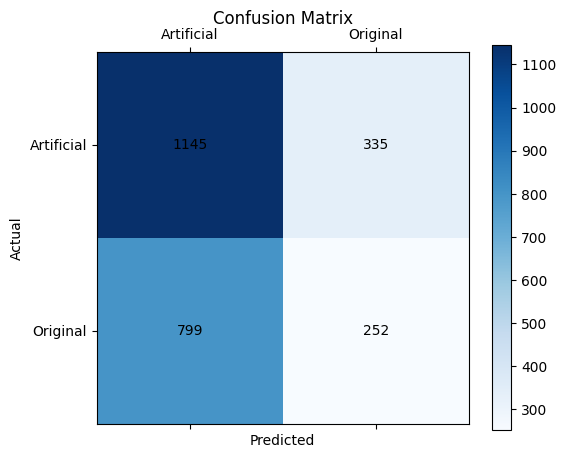

              precision    recall  f1-score   support

  Artificial       0.59      0.77      0.67      1480
    Original       0.43      0.24      0.31      1051

    accuracy                           0.55      2531
   macro avg       0.51      0.51      0.49      2531
weighted avg       0.52      0.55      0.52      2531



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

# Plot with matplotlib
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix', pad=20)
fig.colorbar(cax)

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Annotate each cell
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center')

plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))


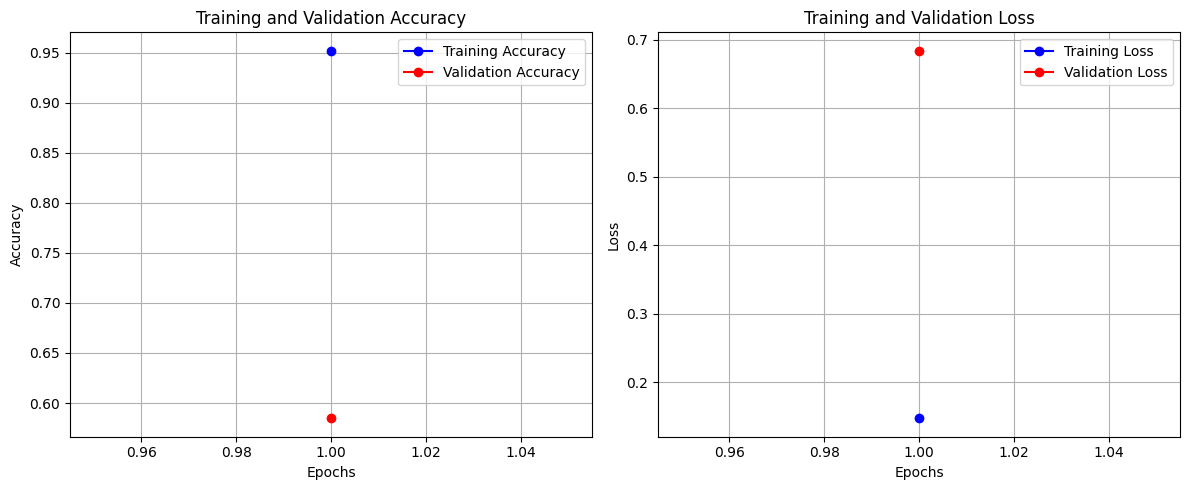

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
